<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/Soma_Size/Cell_pose_AR_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib --quiet

In [2]:

import tifffile
import os
import numpy as np
import matplotlib.pyplot as plt


In [3]:
source_directory = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/'


my_tiffs = list()
for rt,dirs,file_list in os.walk(source_directory):
    for file in file_list:
        if 'tif' in file:
            my_tiffs.append(os.path.join(rt,file))
print(my_tiffs)

curr_tif = my_tiffs[0]

['C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-22-22_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-22-22_S001_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-22-22__S001_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-24-22_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-24-22__S001_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-25-22_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-25-22__S001_DG_40X_2XZoom_1.tif']


In [4]:
curr_tif = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-25-22__S001_DG_40X_2XZoom_1.tif'

In [6]:
def dimension_to_front(data,dim_x):
    dim_list = list(np.arange(len(data.shape)))
    transpose = [dim_list[dim_x]] + dim_list[:dim_x] + dim_list[dim_x+1:]
    data_t = data.transpose(transpose)
    invs_transpose = list(np.argsort(transpose))
    return data_t, transpose, invs_transpose

def norm_channels(im_data,tiff_format):
    color_dim = tiff_format.index('c')
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),[99,1])
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    return im_data
# dimension_to_front(tiff_data,2)

In [7]:
tiff_format = 'zcyx'
tiff_data = tifffile.imread(curr_tif)
tiff_data = norm_channels(tiff_data,'zcyx')



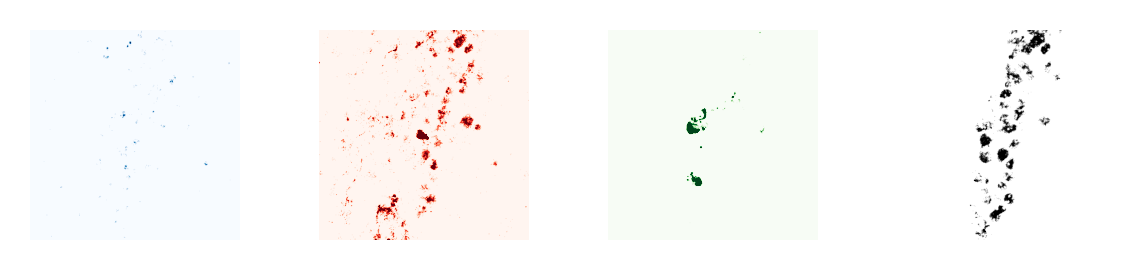

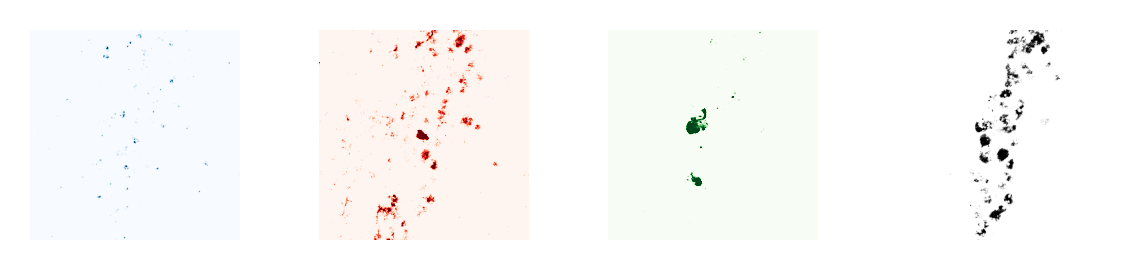

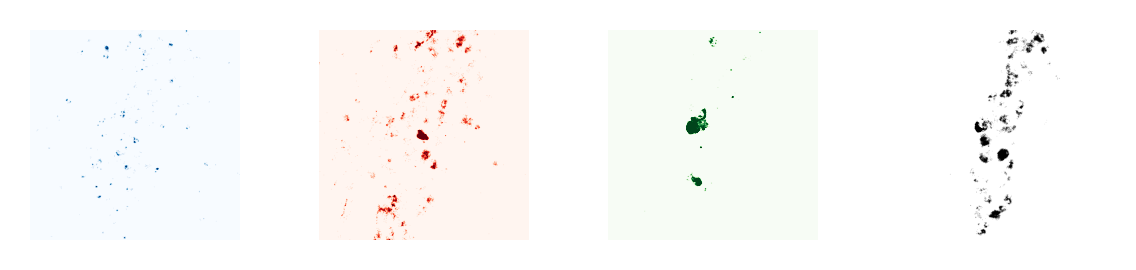

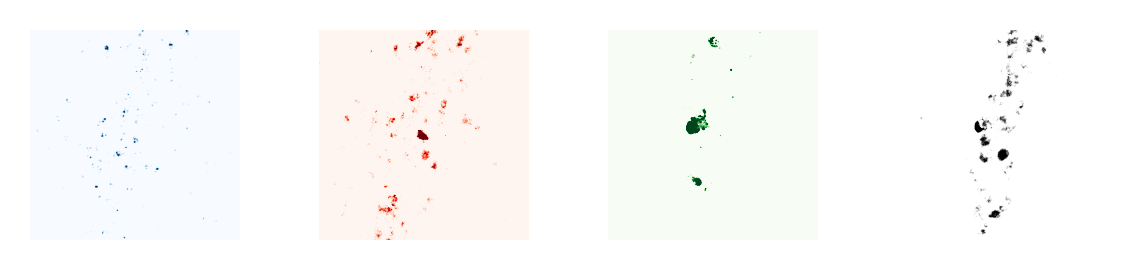

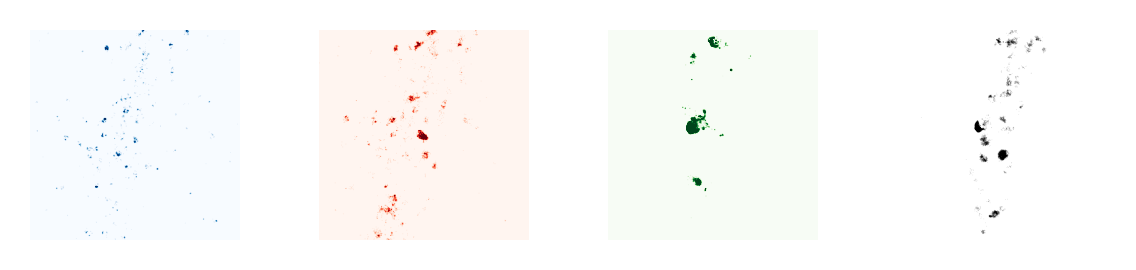

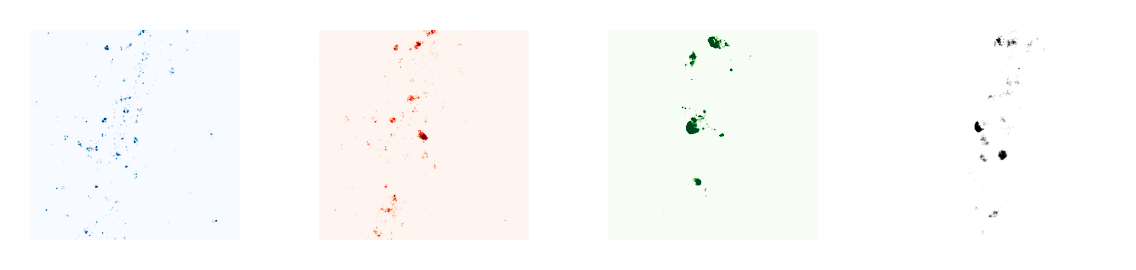

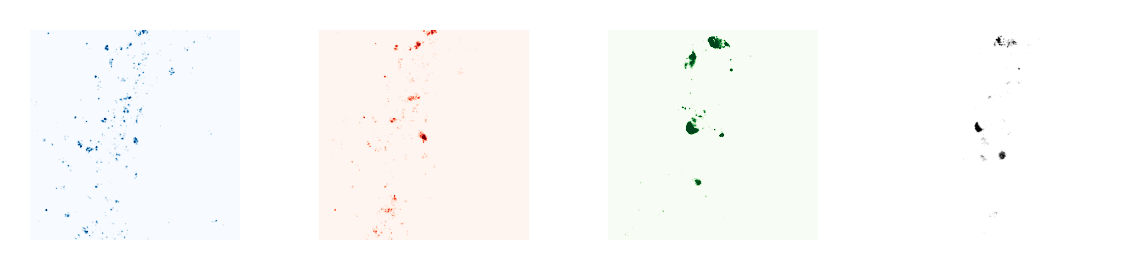

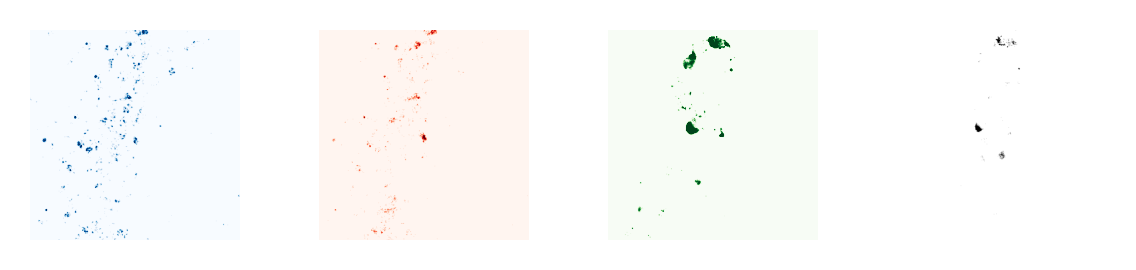

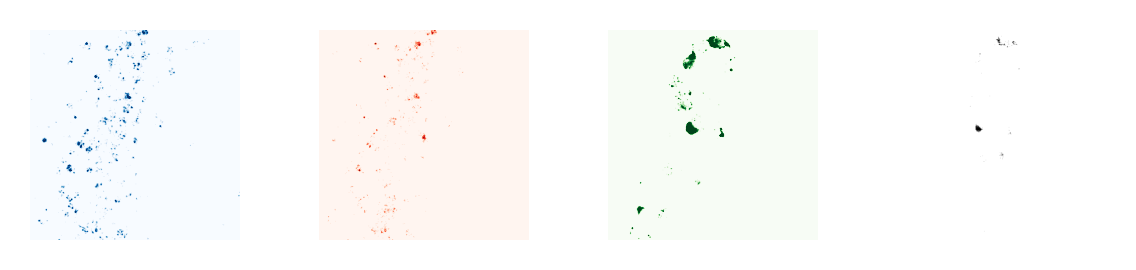

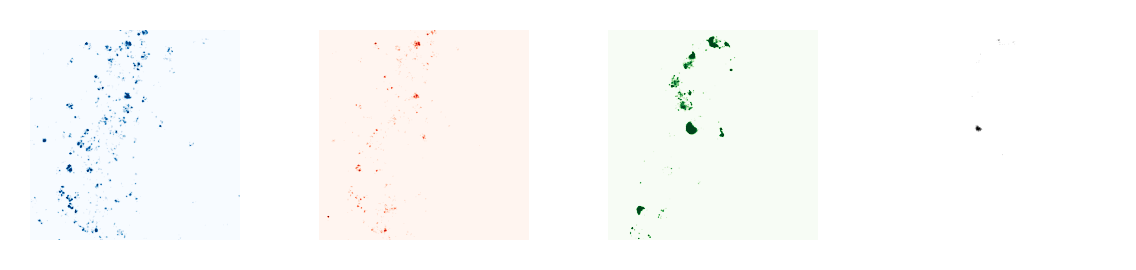

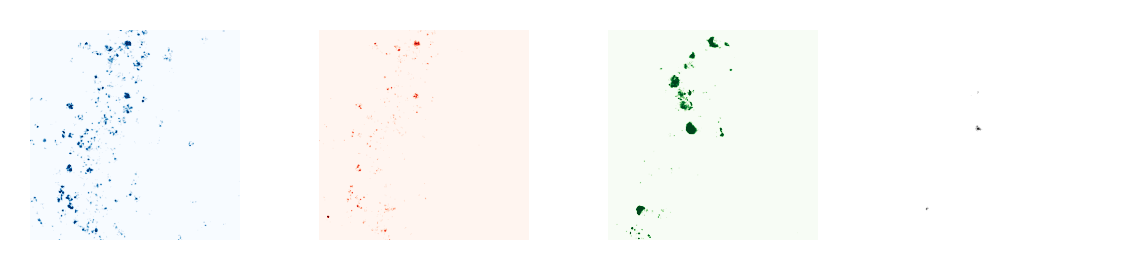

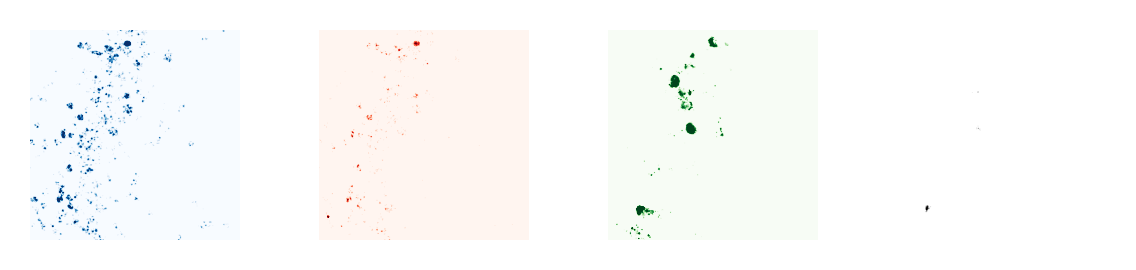

In [8]:
for z in range(tiff_data.shape[0]):
    num_c = tiff_data.shape[1]
    fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
    colors = ['Blues','Reds','Greens','gray_r']
    for c in range(num_c):
        ax[c].imshow(tiff_data[z,c], cmap=colors[c],vmin=0,vmax=1)
        ax[c].axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
!pip install cellpose --quiet
from cellpose import models

In [10]:

cell_channel = 3
nuclear_channel = 0
channel_axis = 1
model = models.Cellpose(model_type='cyto')



In [ ]:
results = model.eval(tiff_data, channels=[cell_channel, nuclear_channel], channel_axis=channel_axis, diameter=30.0,do_3D=True)